<a href="https://colab.research.google.com/github/Hanurohan/PYTHON/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install yfinance scikit-learn pandas matplotlib seaborn tensorflow --quiet

In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense

sns.set_style("whitegrid")

In [11]:
def load_stock(symbol, start_date="2016-01-01"):
    df = yf.download(symbol, start=start_date)
    df = df[['Close']].dropna()
    return df

def prepare_data(df, seq_len=60, train_ratio=0.8):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(seq_len, len(scaled)):
        X.append(scaled[i-seq_len:i])
        y.append(scaled[i])

    X, y = np.array(X), np.array(y)
    split = int(train_ratio * len(X))

    return X[:split], y[:split], X[split:], y[split:], scaler


In [12]:
def build_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(64)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_and_evaluate(df, seq_len=60):
    X_train, y_train, X_test, y_test, scaler = prepare_data(df, seq_len)
    model = build_model((seq_len, 1))
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    # Metrics
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f"📏 MAE: ₹{mae:.2f} | 📐 RMSE: ₹{rmse:.2f}")

    return model, scaler, y_test_inv, y_pred_inv


In [25]:
def get_recommendation(current_price, predicted_price, threshold=0.5):
    diff = predicted_price - current_price
    if diff > threshold:
        action = "BUY"
        reason = f"I predict a rise of ₹{diff:.2f}. Likely uptrend."
    elif diff < -threshold:
        action = "SELL"
        reason = f"I predict a drop of ₹{abs(diff):.2f}. Downtrend expected."
    else:
        action = "HOLD"
        reason = "Predicted movement is negligible. No clear trend."
    return action, reason


In [24]:
def predict_and_recommend(stock_symbol, seq_len=60):
    print(f"\n🔍 Analyzing {stock_symbol}...")
    try:
        data = load_stock(stock_symbol)
        model, scaler, y_test, y_pred = train_and_evaluate(data)

        current_price = float(data['Close'].iloc[-1])
        predicted_price = float(y_pred[-1][0])
        action, explanation = get_recommendation(current_price, predicted_price)

        # ✅ Fixed Plot for Last 7 Days
        last_week = data[-7:]
        plt.figure(figsize=(10, 4))
        plt.plot(last_week.index, last_week['Close'].values.flatten(), marker='o', linestyle='-', color='green')
        plt.title(f"{stock_symbol} - Last 7 Days")
        plt.xlabel("Date")
        plt.ylabel("Price ₹")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Output
        print(f"📌 Current Price: ₹{current_price:.2f}")
        print(f"🔮 Predicted Price (Tomorrow): ₹{predicted_price:.2f}")
        print(f"📈 Recommended Action: {action}")
        print(f"🤖 Why? {explanation}")

    except Exception as e:
        print(f"❌ Could not analyze {stock_symbol}. Error: {str(e)}")



🔍 Analyzing RELIANCE.NS...


/tmp/ipython-input-308044009.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
📏 MAE: ₹36.63 | 📐 RMSE: ₹44.97


/tmp/ipython-input-152640210.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data['Close'].iloc[-1])


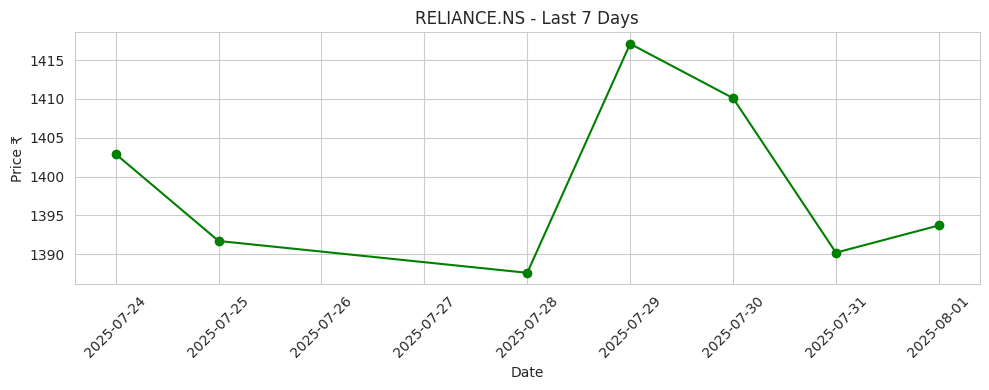

📌 Current Price: ₹1393.70
🔮 Predicted Price (Tomorrow): ₹1375.93
📈 Recommended Action: SELL
🤖 Why? Model predicts a drop of ₹17.77. Downtrend expected.

🔍 Analyzing TCS.NS...


/tmp/ipython-input-308044009.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
📏 MAE: ₹90.23 | 📐 RMSE: ₹118.70


/tmp/ipython-input-152640210.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data['Close'].iloc[-1])


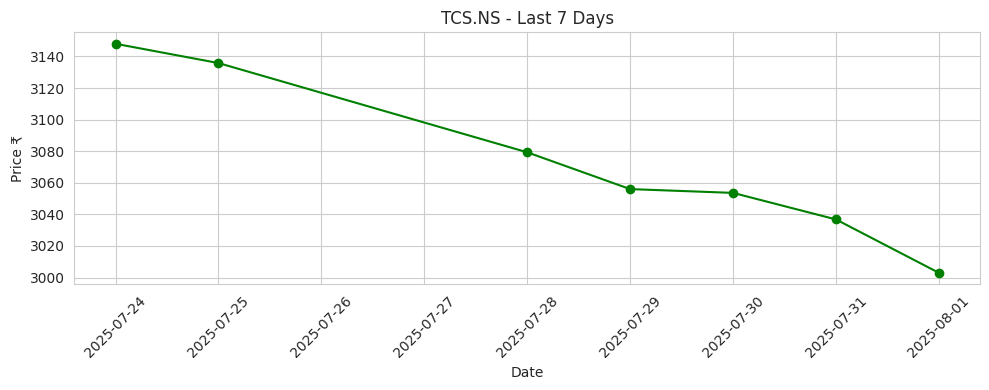

📌 Current Price: ₹3003.00
🔮 Predicted Price (Tomorrow): ₹3131.96
📈 Recommended Action: BUY
🤖 Why? Model predicts a rise of ₹128.96. Likely uptrend.

🔍 Analyzing HDFCBANK.NS...


/tmp/ipython-input-308044009.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
📏 MAE: ₹36.98 | 📐 RMSE: ₹46.49


/tmp/ipython-input-152640210.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data['Close'].iloc[-1])


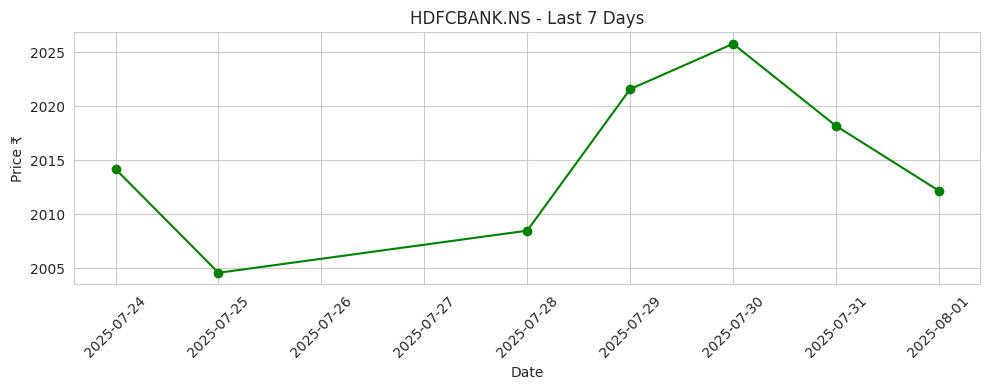

📌 Current Price: ₹2012.20
🔮 Predicted Price (Tomorrow): ₹1961.66
📈 Recommended Action: SELL
🤖 Why? Model predicts a drop of ₹50.54. Downtrend expected.

🔍 Analyzing INFY.NS...


/tmp/ipython-input-308044009.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
📏 MAE: ₹65.09 | 📐 RMSE: ₹77.70


/tmp/ipython-input-152640210.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data['Close'].iloc[-1])


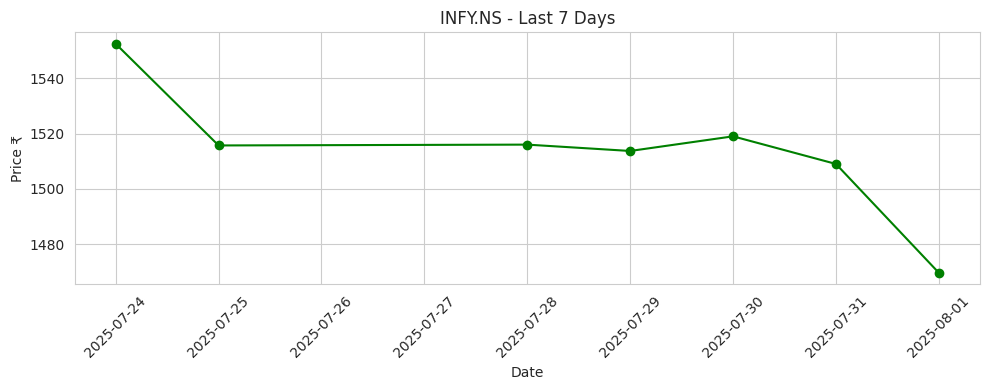

📌 Current Price: ₹1469.60
🔮 Predicted Price (Tomorrow): ₹1480.98
📈 Recommended Action: BUY
🤖 Why? Model predicts a rise of ₹11.38. Likely uptrend.


In [23]:
# 🧾 User's portfolio (change or expand as needed)
user_portfolio = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS"]

# 🔁 Predict for each
for stock in user_portfolio:
    predict_and_recommend(stock)
